In [1]:
import GAN.models as models
import GAN.cms_datasets as cms
import GAN.plotting as plotting
import GAN.preprocessing as preprocessing
import GAN.base as base

Using TensorFlow backend.


In [62]:
import GAN.utils as utils

# reload(utils)

class Parameters(utils.Parameters):
    
    load_datasets=utils.param(["moriond_v9","abs(ScEta) < 1.5"])

#     c_names = utils.param(['Pt','ScEta','Phi','rho'])
#     x_names = utils.param(['R9','SigmaIeIe','S4','EtaWidth','PhiWidth','CovarianceIetaIphi',
#                'CovarianceIphiIphi', ])
    c_names = utils.param(['Phi','ScEta','Pt','rho','run'])
    x_names = utils.param(['EtaWidth','R9','SigmaIeIe','S4','PhiWidth','CovarianceIetaIphi',
                           'CovarianceIphiIphi'])
#     c_names = utils.param(['ScEta'])
#     x_names = utils.param(['R9'])
    sample_from_data = ['run']
    reweight = utils.param(['rewei_zee_barrel.npy','rewei_zee_pt_abs_barrel.npy','rewei_zee_pu_barrel.npy'])
#    cleaning = utils.param('cleaning_zee_m_pt_barrel.hd5')
    cleaning = utils.param('cleaning_zee_barrel.hd5')
    mcweight = utils.param('weight')
    use_abs_weight = utils.param(True)
    
    feat_transform = utils.param('minmax')
#    feat_transform = utils.param('gaus')

    g_opts=utils.param(dict(#name="G_512x8",kernel_sizes=[512]*8,
                            name="G_512to64x8",#kernel_sizes=[128,128,256,256,512,512,1024,1024],#
                                                 kernel_sizes=[64,64,128,128,256,256,512,512],
                            do_weight_reg=1e-5,do_last_l1reg=1e-5))

#     g_opts=utils.param(dict(name="G_512x8",kernel_sizes=[512]*8,
#                             #name="G_512to64x8",kernel_sizes=[64,64,128,128,256,256,512,512],
#                             do_weight_reg=1e-4,do_last_l1reg=1e-3,
#                             do_nl_activ=["tanh","relu"]*4
#                            ))

#     g_opts=utils.param(dict(name="G_128to32x7",kernel_sizes=[32]+[64]*2+[128]*2, # krnel_sizes=[128]*7,
#                             # do_nl_activ="tanh",
#                             do_nl_activ=["relu","tanh"]*3+["relu"],
#                             do_bn=False,do_dropout=False))
    pretrain_g = utils.param(False)
    d_opts=utils.param(dict(name="D_1024to32x6",kernel_sizes=[1024,512,128,64,32],do_bn=False,
                        clip_weights=2.e-2,activation=None)) # weights clipping and no actication

    dm_opts=utils.param(dict(optimizer="RMSprop",opt_kwargs=dict(lr=1e-5,decay=1e-6)))#, decay=6e-6)))
    am_opts=utils.param(dict(optimizer="RMSprop",opt_kwargs=dict(lr=1e-5,decay=1e-6)))#, decay=6e-6)))
    
    
    epochs=utils.param(200)
    batch_size=utils.param(4096)
    plot_every=utils.param(10)
    
    frac_data=utils.param(10)
    
    loss = utils.param("wgan_loss") # use WGAN loss 
    gan_targets = utils.param('gan_targets_hinge') # hinge targets are 1, -1 instead of 0, 1
    schedule = utils.param([0]*5+[1]*1) # number of critic iterations per generator iterations
    
    monitor_dir = utils.param('log')
    
    batch = utils.param(False)

class MyApp(utils.MyApp):
    classes = utils.List([Parameters])

# Read all parameters above from command line. 
# Note: names are all converted to be all capital
notebook_parameters = Parameters(MyApp()).get_params()

# copy parameters to global scope
globals().update(notebook_parameters)
DM_OPTS.update( {"loss":LOSS} )
AM_OPTS.update( {"loss":LOSS} )


plotting.batch = BATCH 

notebook_parameters

{'AM_OPTS': {'loss': 'wgan_loss',
  'opt_kwargs': {'decay': 1e-06, 'lr': 1e-05},
  'optimizer': 'RMSprop'},
 'BATCH': False,
 'BATCH_SIZE': 4096,
 'CLEANING': 'cleaning_zee_m_pt_barrel.hd5',
 'C_NAMES': ['Phi', 'ScEta', 'rho', 'Pt', 'rho', 'run'],
 'DM_OPTS': {'loss': 'wgan_loss',
  'opt_kwargs': {'decay': 1e-06, 'lr': 1e-05},
  'optimizer': 'RMSprop'},
 'D_OPTS': {'activation': None,
  'clip_weights': 0.02,
  'do_bn': False,
  'kernel_sizes': [1024, 512, 128, 64, 32],
  'name': 'D_1024to32x6'},
 'EPOCHS': 200,
 'FEAT_TRANSFORM': 'minmax',
 'FRAC_DATA': 10,
 'GAN_TARGETS': 'gan_targets_hinge',
 'G_OPTS': {'do_last_l1reg': 1e-05,
  'do_weight_reg': 1e-05,
  'kernel_sizes': [64, 64, 128, 128, 256, 256, 512, 512],
  'name': 'G_512to64x8'},
 'LOAD_DATASETS': ['moriond_v9', 'abs(ScEta) < 1.5'],
 'LOSS': 'wgan_loss',
 'MCWEIGHT': 'weight',
 'MONITOR_DIR': 'log',
 'PLOT_EVERY': 10,
 'PRETRAIN_G': False,
 'REWEIGHT': ['rewei_zee_barrel.npy',
  'rewei_zee_pt_abs_barrel.npy',
  'rewei_zee_pu_bar

In [63]:
# reload(cms)

data,mc = cms.load_zee(*LOAD_DATASETS)


In [64]:
data.columns

Index(['index', 'run', 'rho', 'nvtx', 'mass', 'weight', 'SigMoM', 'Pt',
       'ScEta', 'Phi', 'R9', 'S4', 'SigmaIeIe', 'EtaWidth', 'PhiWidth',
       'CovarianceIphiIphi', 'SigmaRR', 'ScEnergy', 'CovarianceIetaIphi',
       'PhoIso03', 'ChIso03', 'ChIso03worst', 'ScPreshowerEnergy', 'PhoIDMVA',
       'SigEOverE', 'run_quantile'],
      dtype='object')

In [65]:
mc.columns

Index(['index', 'run', 'rho', 'nvtx', 'mass', 'weight', 'SigMoM', 'Pt',
       'ScEta', 'Phi', 'R9', 'S4', 'SigmaIeIe', 'EtaWidth', 'PhiWidth',
       'CovarianceIphiIphi', 'SigmaRR', 'ScEnergy', 'CovarianceIetaIphi',
       'PhoIso03', 'ChIso03', 'ChIso03worst', 'ScPreshowerEnergy', 'PhoIDMVA',
       'SigEOverE'],
      dtype='object')

In [66]:
# (data[thr_down.index]>=thr_down).all(axis=1).sum()

In [67]:
if not CLEANING is None:
    print('cleaning data and mc')
    thr_up = pd.read_hdf(CLEANING,'thr_up')
    thr_down = pd.read_hdf(CLEANING,'thr_down')
    nevts_data = data.shape[0]
    nevts_mc = mc.shape[0]
    data = data[ ((data[thr_down.index] >= thr_down) & (data[thr_up.index] <= thr_up)).all(axis=1) ]
    mc = mc[ ((mc[thr_down.index] >= thr_down) & (mc[thr_up.index] <= thr_up)).all(axis=1) ]
    print('cleaning eff (data,mc): %1.2f % 1.2f' % (  data.shape[0] / nevts_data, mc.shape[0] / nevts_mc  ))
    

cleaning data and mc
cleaning eff (data,mc): 0.91  0.94


In [68]:
for col in SAMPLE_FROM_DATA:
    print('sampling', col)
    mc[col] = data[col].sample(mc.shape[0]).values
    

sampling run


In [69]:
# mc['run']

In [70]:
c_names = C_NAMES
x_names = X_NAMES

data_c = data[c_names]
data_x = data[x_names]

mc_c = mc[c_names]
mc_x = mc[x_names]


In [71]:
data_x.columns, data_x.shape, data_c.columns, data_c.shape

(Index(['EtaWidth', 'R9', 'SigmaIeIe', 'S4', 'PhiWidth', 'CovarianceIetaIphi',
        'CovarianceIphiIphi'],
       dtype='object'),
 (15944183, 7),
 Index(['Phi', 'ScEta', 'rho', 'Pt', 'rho', 'run'], dtype='object'),
 (15944183, 6))

In [72]:
data_x.columns, data_c.columns

(Index(['EtaWidth', 'R9', 'SigmaIeIe', 'S4', 'PhiWidth', 'CovarianceIetaIphi',
        'CovarianceIphiIphi'],
       dtype='object'),
 Index(['Phi', 'ScEta', 'rho', 'Pt', 'rho', 'run'], dtype='object'))

In [73]:
mc_x.columns, mc_c.columns


(Index(['EtaWidth', 'R9', 'SigmaIeIe', 'S4', 'PhiWidth', 'CovarianceIetaIphi',
        'CovarianceIphiIphi'],
       dtype='object'),
 Index(['Phi', 'ScEta', 'rho', 'Pt', 'rho', 'run'], dtype='object'))

In [74]:
# reload(preprocessing)
if MCWEIGHT is None:
    mc_w = np.ones(mc_x.shape[0])
else:
    mc_w = mc[MCWEIGHT].values

if USE_ABS_WEIGHT:
    mc_w = np.abs(mc_w)

if not REWEIGHT is None:
    for fil in REWEIGHT:
        info = np.load(fil)
        inputs = info[0]
        weights = info[1]
        bins = info[2:]
        # print(bins[1])
        print('weighting',inputs)
        mc_w *= preprocessing.reweight(mc,inputs,bins,weights,base=None)
    
data_w = np.ones(data_x.shape[0])

weighting ['ScEta', 'Phi']
weighting ['Pt']
weighting ['run', 'rho']


In [75]:
# reload(models)

xz_shape = (1,len(x_names))
c_shape = (1,len(c_names))
gan = models.MyFFGAN( xz_shape, xz_shape, c_shape=c_shape,
                     g_opts=G_OPTS,
                     d_opts=D_OPTS,
                     dm_opts=DM_OPTS,
                     am_opts=AM_OPTS,
                     gan_targets=GAN_TARGETS
                    )

In [76]:
gan.get_generator()

(1, 7)


In [77]:
gan.get_discriminator()

WeightClip 0.02
WeightClip 0.02
WeightClip 0.02
WeightClip 0.02
WeightClip 0.02
WeightClip 0.02


(<keras.engine.training.Model at 0x2ba907a4d128>,
 <keras.engine.training.Model at 0x2ba907a4d7b8>)

In [78]:
gan.adversarial_compile(loss=LOSS,schedule=SCHEDULE)

wgan_loss


In [79]:
gan.get_generator().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
G_512to64x8_c_input (InputLayer) (None, 1, 6)          0                                            
____________________________________________________________________________________________________
G_512to64x8_input (InputLayer)   (None, 1, 7)          0                                            
____________________________________________________________________________________________________
G_512to64x8_all_inputs (Concaten (None, 1, 13)         0           G_512to64x8_c_input[0][0]        
                                                                   G_512to64x8_input[0][0]          
____________________________________________________________________________________________________
G_512to64x8_up1_dense (Dense)    (None, 1, 512)        7168        G_512to64x8_all_inputs[0

In [80]:
gan.get_discriminator()[0].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
D_1024to32x6_c_input (InputLayer (None, 1, 6)          0                                            
____________________________________________________________________________________________________
D_1024to32x6_input (InputLayer)  (None, 1, 7)          0                                            
____________________________________________________________________________________________________
D_1024to32x6_all_inputs (Concate (None, 1, 13)         0           D_1024to32x6_c_input[0][0]       
                                                                   D_1024to32x6_input[0][0]         
____________________________________________________________________________________________________
D_1024to32x6_down1_dense (Dense) (None, 1, 1024)       14336       D_1024to32x6_all_inputs[

In [81]:
gan.get_discriminator()[1].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
D_1024to32x6_c_input (InputLayer (None, 1, 6)          0                                            
____________________________________________________________________________________________________
D_1024to32x6_input (InputLayer)  (None, 1, 7)          0                                            
____________________________________________________________________________________________________
D_1024to32x6_all_inputs (Concate (None, 1, 13)         0           D_1024to32x6_c_input[0][0]       
                                                                   D_1024to32x6_input[0][0]         
____________________________________________________________________________________________________
D_1024to32x6_down1_dense (Dense) (None, 1, 1024)       14336       D_1024to32x6_all_inputs[

In [82]:
set(gan.am[0].trainable_weights)-set(gan.am[1].trainable_weights)

set()

In [83]:
# reload(preprocessing)

data_x,data_c,mc_x,mc_c,scaler_x,scaler_c = preprocessing.transform(data_x,data_c,mc_x,mc_c,FEAT_TRANSFORM)


In [84]:
data_x.shape,mc_x.shape

((15944183, 1, 7), (9044826, 1, 7))

In [85]:
data_x[2].max(),mc_x[2].max()

(0.47409417445056729, 0.64281982551866179)

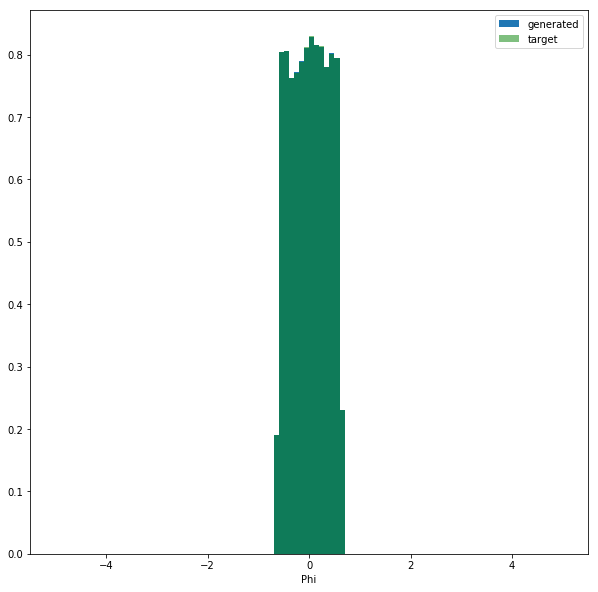

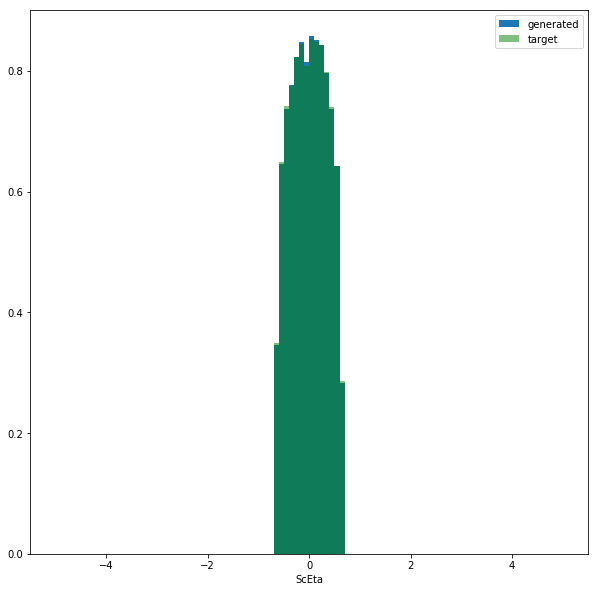

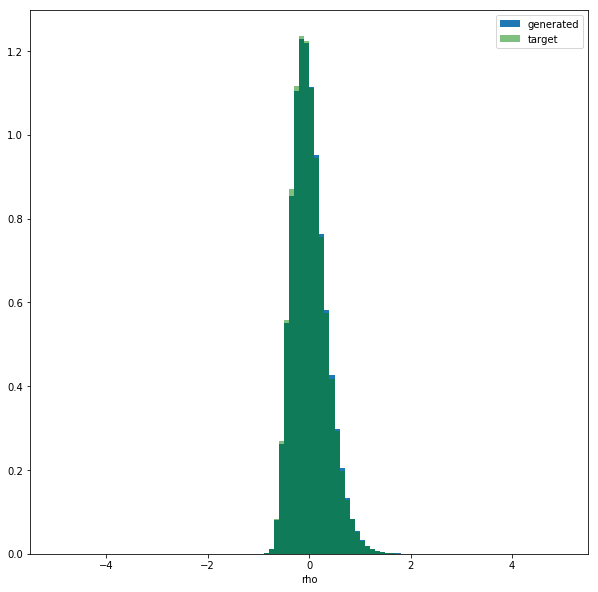

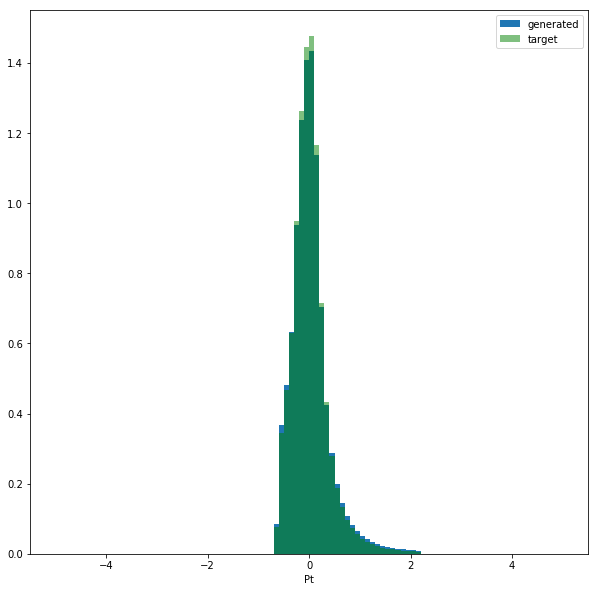

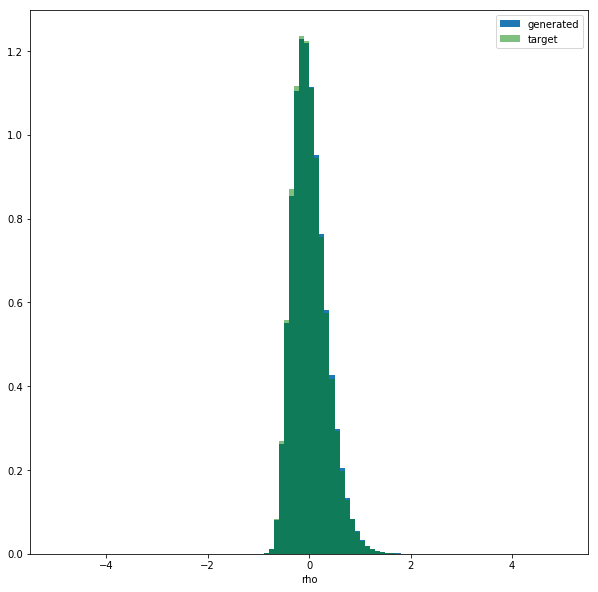

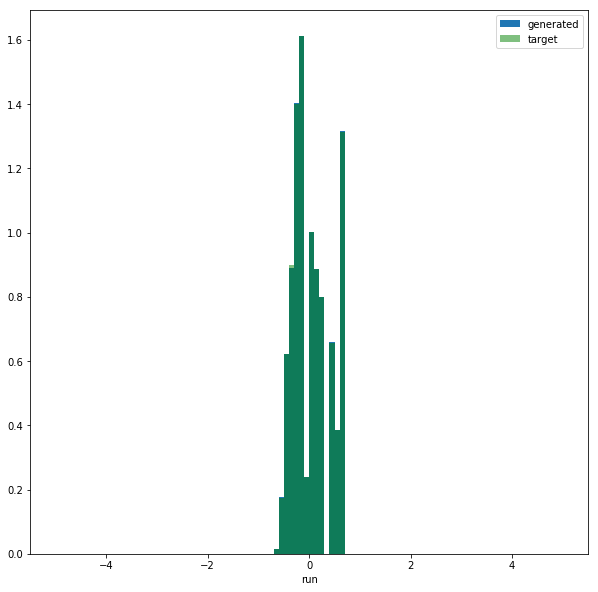

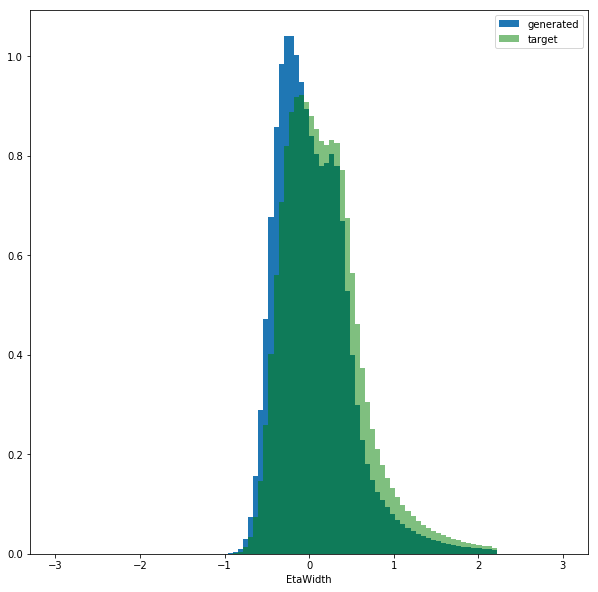

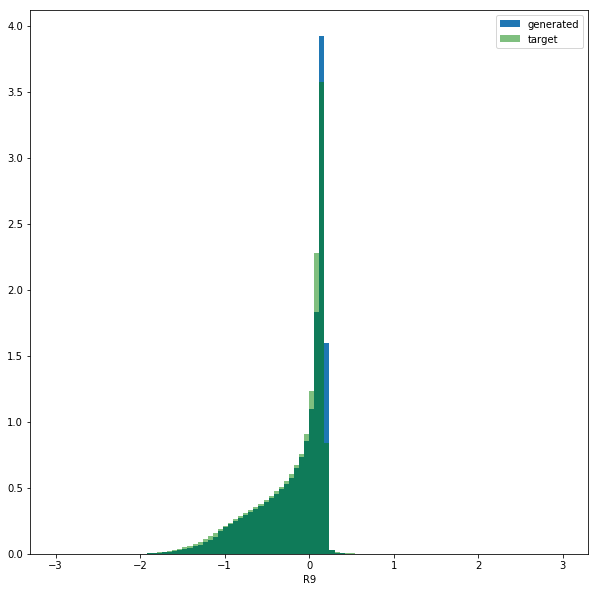

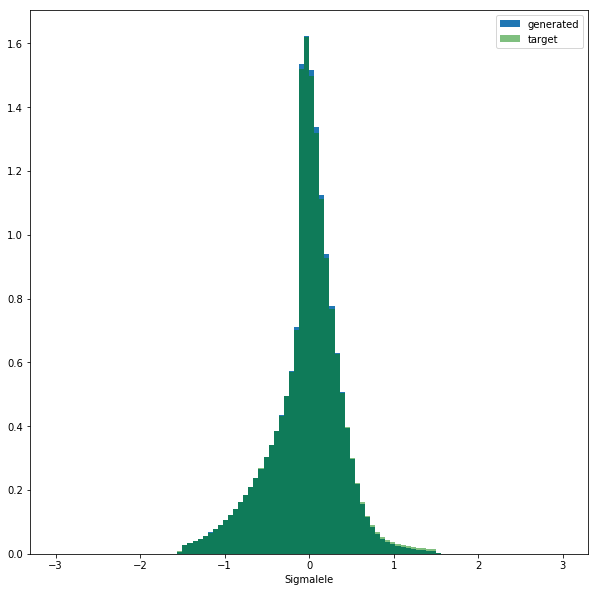

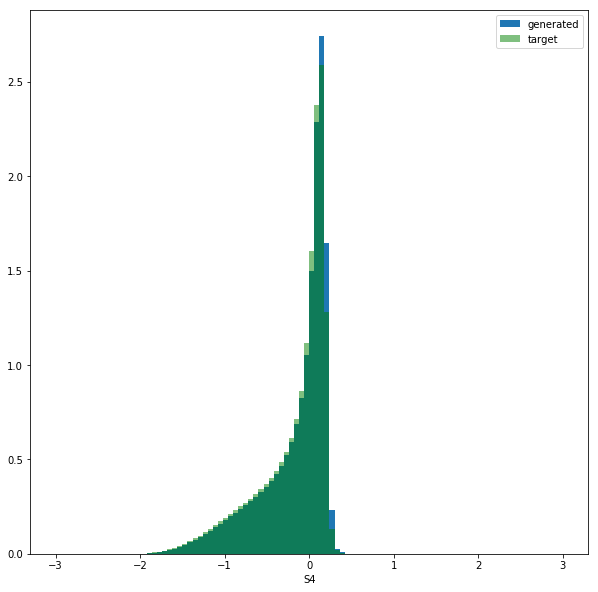

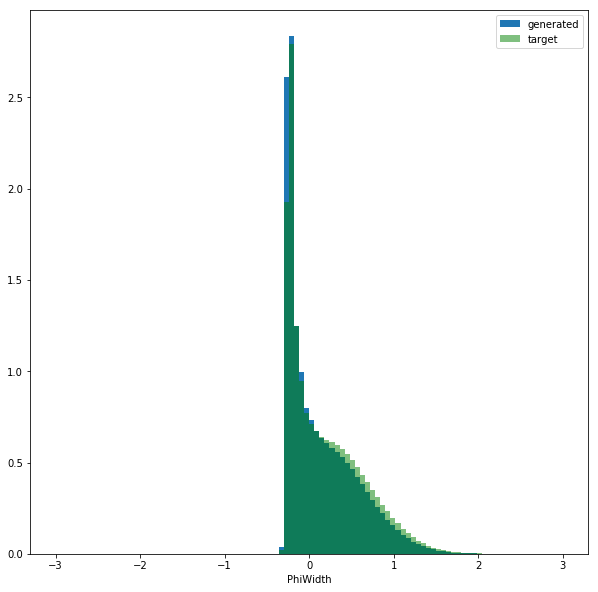

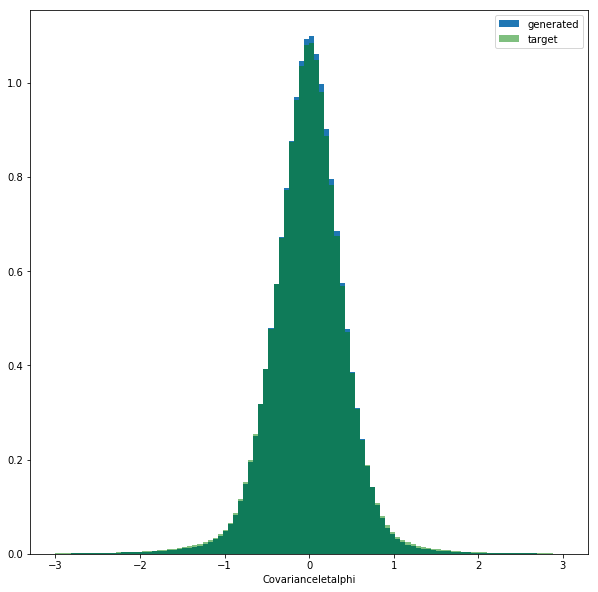

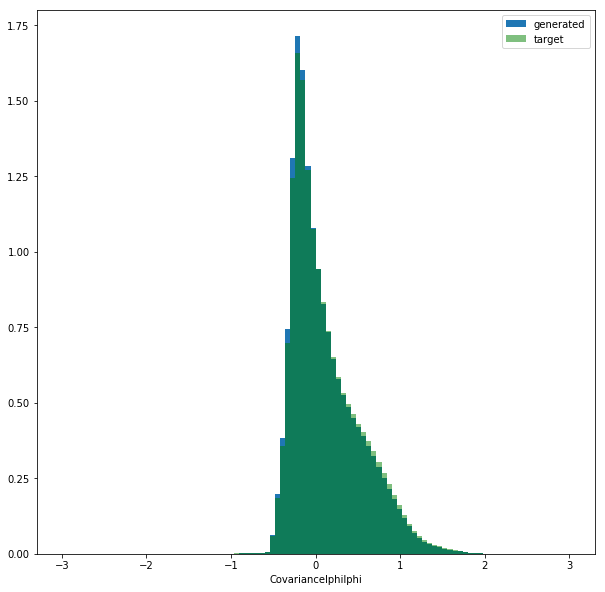

In [86]:
for ic in range(len(c_names)):
    plotting.plot_hists(data_c[:,0,ic],mc_c[:,0,ic],generated_w=mc_w,bins=100)#,range=[-3,3])
    plt.xlabel(c_names[ic])
    plt.show()

for ix in range(len(x_names)):
    plotting.plot_hists(data_x[:,0,ix],mc_x[:,0,ix],generated_w=mc_w,bins=100,range=[-3,3])
    plt.xlabel(x_names[ix])
    plt.show()



In [ ]:
nmax = min(data_x.shape[0]//FRAC_DATA,mc_x.shape[0])

data_x_train,data_x_test,data_c_train,data_c_test,data_w_train,data_w_test = cms.train_test_split(data_x[:nmax],data_c[:nmax],data_w[:nmax],test_size=0.1)
mc_x_train,mc_x_test,mc_c_train,mc_c_test,mc_w_train,mc_w_test = cms.train_test_split(mc_x[:nmax],mc_c[:nmax],mc_w[:nmax],test_size=0.1)

wscl = data_w[:nmax].sum() / mc_w[:nmax].sum()
mc_w_train *= wscl
mc_w_test *= wscl

In [ ]:
print(nmax,mc_w_train.sum()/data_w_train.sum())

In [ ]:
from keras.optimizers import RMSprop

if PRETRAIN_G:
    generator = gan.get_generator()
    generator.compile(loss="mse",optimizer=RMSprop(lr=1.e-3))
    generator.fit( [mc_c_train,mc_x_train], [mc_c_train,mc_x_train], sample_weight=[mc_w_train,mc_w_train], epochs=1, batch_size=BATCH_SIZE  )

In [ ]:
# reload(base)

initial_epoch = 0
# if hasattr(gan.model,"history"):
#     initial_epoch = gan.model.history.epoch[-1] + 1

do = dict(
    x_train=data_x_train,
    z_train=mc_x_train,
    c_x_train=data_c_train,
    c_z_train=mc_c_train,
    w_x_train = data_w_train,
    w_z_train = mc_w_train,
          
    x_test=data_x_test,
    z_test=mc_x_test,
    c_x_test=data_c_test,
    c_z_test=mc_c_test,
    w_x_test = data_w_test,
    w_z_test = mc_w_test,
    
    n_epochs=EPOCHS + initial_epoch - 1,
    initial_epoch=initial_epoch,
    batch_size=BATCH_SIZE,
    plot_every=PLOT_EVERY,
    
    monitor_dir=MONITOR_DIR
)

exc = None
try:
    gan.adversarial_fit(**do)
except Exception as e:
    exc = e

In [ ]:
if not exc is None:
    print(exc)